In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cuda


In [3]:
words = open("names.txt", "r").read().splitlines()

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

In [5]:
vocab_len = len(stoi)
word_count = len(words)
print(f"{vocab_len=}")
print(f"{word_count=}")

vocab_len=27
word_count=32033


In [ ]:
block_size = 3
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '------>', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
# Split dataset
# train: evaluate at training time
# test: evaluate after training
# Validation: Evaluate during hyperparam tuning
# 80/10/10


def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
# C is a lookup table / embedding table
g = torch.Generator(device=device).manual_seed(123456789)
C = torch.randn((27, 2))

In [ ]:
emb = C[X]
emb.shape

In [ ]:
# input to weights = 3*2 for 3 block size and 2d embedding
w1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
# emb.view(32,6) reshapes the tensor
# can use torch.reshape however that creates a copy and allocates additional memory for the new tensor

# for shape of view() you can use emb.shape[0] or "-1" -1 will make torch figure out the dim based on the other dim size and total num elem

h = torch.tanh(emb.view(emb.shape[0], 6) @ w1 + b1)

In [ ]:
h.shape

In [ ]:
w2 = torch.rand((100, 27))
b2 = torch.rand(27)

logits = h @ w2 + b2
logits.shape

In [ ]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

# Above implementation can be done using torch.cross_entropy()
# Above imp creates new tensors in memory
# foward pass and backward pass more efficient
# torch.exp() can overflow with large positive values. cross_entropy offsets the input array by its max so that the result is safe
loss = F.cross_entropy(logits, Y)
loss

In [ ]:
# Proper Code

In [8]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [9]:
g = torch.Generator(device=device).manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.rand((200, 27), generator=g)
b2 = torch.rand(27, generator=g)
params = [C, w1, b1, w2, b2]

In [10]:
sum(p.nelement() for p in params)

11897

In [11]:
for p in params:
    p.requires_grad = True

In [12]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [13]:
lri = []
lossi = []
stepi = []

In [15]:
for i in range(50000):
    # Forward Pass
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 30) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1
    for p in params:
        p.data += -lr * p.grad
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(f"{loss.item()=}")

loss.item()=2.037353992462158


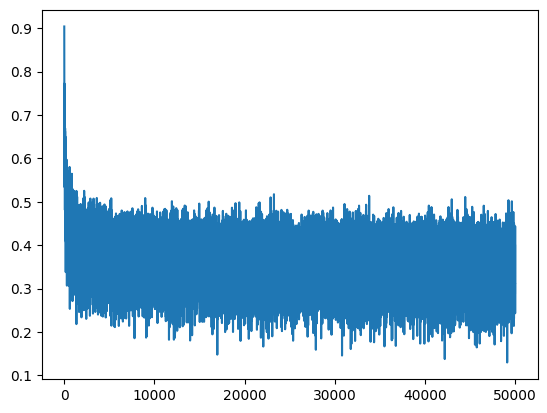

In [16]:
plt.plot(stepi, lossi)

In [21]:
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], 30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2611, device='cuda:0', grad_fn=<NllLossBackward0>)

In [27]:
# Sample from model

g = torch.Generator(12)
block_size = 3

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

kallet.
nilo.
kaisyra.
jeh.
amarlan.
jer.
avelyn.
eyda.
haele.
didonettummercy.
zalie.
aad.
guydatalexlamarcarleiah.
ahrancidon.
kas.
andiena.
aleah.
monie.
yairecklegen.
bliysara.
